In [137]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

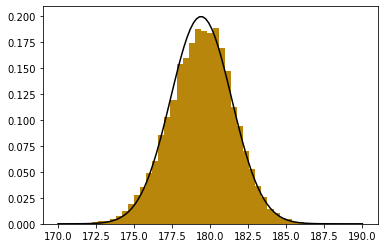

In [145]:
draw = scipy.stats.norm.rvs(loc=10, scale = .5, size = 10000)

def temperature(pressure):
    return 373.15/(1-((8.3*373.15)/(18*2257))*np.log(pressure))-273.15

plt.hist(temperature(draw), color = 'darkgoldenrod', density=True, bins = 40)
x = np.linspace(170,190,100)
plt.plot(x, scipy.stats.norm.pdf(x,loc=179.4, scale=2), color = "black")
plt.show()

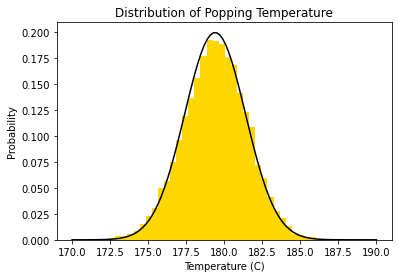

In [157]:
draw = scipy.stats.norm.rvs(loc=10, scale = .5, size = 10000)

def temperature(pressure):
    return 373.15/(1-((8.3*373.15)/(18*2257))*np.log(pressure))-273.15

plt.hist(temperature(draw), color = 'gold', density=True, bins = 40)
x = np.linspace(170,190,100)
plt.plot(x, scipy.stats.norm.pdf(x,loc=179.4, scale=2), color = "black")
plt.title("Distribution of Popping Temperature")
plt.xlabel("Temperature (C)")
plt.ylabel("Probability")
plt.savefig("distribution")
plt.show()

In [139]:
def model_kernal(num_kernal, T_s, T_0, r , t_step, burn_function, tau, c):
    
    pop_temp = np.random.normal(loc=179.4, scale=2, size=num_kernal)
    
    def time(temperature,T_s,r):
        return -np.log((temperature - T_s)/(T_0 - T_s))/r
    
    pop_time = time(pop_temp,T_s,r)
    mask = np.isnan(pop_time)
    pop_time[mask] = 0
    last_pop_t = np.max(pop_time)
    pop_time[mask] = np.inf
    first_pop_t = np.min(pop_time)
    
    if burn_function == 1:
        
        c = 185*5.5
        burn_t = lambda T_s: c*np.exp(-T_s/(T_0*2))
        
        burn_after_pop = burn_t(T_s)
        T = np.linspace(first_pop_t - burn_after_first_pop, last_pop_t + burn_after_first_pop, t_step)

        states = []
        for t in T:
            U = []
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            states.append(U) 
        return states, T
    
    elif burn_function == 2:
        

        burn_t = lambda num_pop: 185*5.5*np.exp(-T_s/(T_0*2)) + c/(tau-num_pop)
        
        burn_after_pop = burn_t(T_s)
        T = np.linspace(first_pop_t - 10, last_pop_t + 10, t_step)

        states = []
        num_pop = 0
        for t in T:
            U = []
            burn_after_pop = burn_t(num_pop)
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            num_pop = U.count('p')
            states.append(U) 
        return states, T
        
    

In [140]:
# time it takes to burn
c = 185*5.5
burn_t = lambda T_b: c*np.exp(-T_b/(T_0*2))
print(model_kernal(500, 185, 20, 0.05, 100,2,1,30)[0])

/var/folders/z2/plvrsqjs023g1cmx7k19mhzr0000gn/T/ipykernel_3053/2346274259.py:6: RuntimeWarning: invalid value encountered in log
  return -np.log((temperature - T_s)/(T_0 - T_s))/r


ZeroDivisionError: division by zero

In [127]:
def plot_plate(U,t_space):
    colors = ["darkgoldenrod","gold","black"]
    t = best_time(U)
    model = U[t]
    names = ["Unpopped","Popped","Burned"]
    
    counts = Counter(model)
    counts  = dict(counts)
    fig,ax = plt.subplots(figsize = (8,8))
    for i, corn in enumerate(counts.keys()):
        x = np.random.random(counts[corn])
        y = np.random.random(counts[corn])
        if colors[i] == "darkgoldenrod":
            plt.scatter(x,y,color = colors[i],label = names[i],s = 200)
        else:
            plt.scatter(x,y,color = colors[i],label = names[i],s = 500)
        
    ax.legend(markerscale=.5)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return t_space[t]
        

In [ ]:
def best_time(U):
    best_t = 0
    currentloss = 1e10
    def loss(u,b,p):
        return -np.log(1-b) -np.log(1-u)/4 - np.log(p)
    for t,row in enumerate(U):
        counts = Counter(row)
        counts  = dict(counts)
        newloss = loss(counts['u']/len(row),counts['b']/len(row),counts['p']/len(row))
        
        if newloss < currentloss:
            best_t = t
            currentloss = newloss
    return best_t

In [159]:
def model_kernel(num_kernel, T_s, T_0, r , t_step, burn_function, tau, c):
    """Return the status of each kernal at each time step and the time steps
        Parameters:
            num_kernel    (int): the number of kernals on the stove
            T_s           (float): the temperature of the stove
            T_0           (float): the initial temperature of the kernal (room temperature)
            r             (float): constant for the Newton’s Law of Cooling
            t_step        (int): the number of time steps to check the kernal status
            burn_function (int, 1 or 2): 1: use the first burn function. 2: use the second
            tau           (float): constant for the second burn function
            c             (float): constant for the second burn function
            
        Returns:
            states        ((t_step, num_kernal) list): the status of the kernal at each time step
            T             ((t-step), ndarray): all the time steps
    """
    # randomly draw from the popping temperature distribution
    pop_temp = np.random.normal(loc=179.4, scale=2, size=num_kernel)
    
    # use Newton’s Law of Cooling to calculate the exact time it takes to pop 
    # based on their popping temperature
    def time(temperature,T_s,r):
        return -np.log((temperature - T_s)/(T_0 - T_s))/r
   
    pop_time = time(pop_temp,T_s,r)
    
    # check if the popping temperature if greater than the stove temperature
    mask = np.isnan(pop_time)
    pop_time[mask] = 0
    # take the maximum pop time
    last_pop_t = np.max(pop_time)
    # set the ones that have popping temperature greater than the stove temperature
    # to infinity so they will never pop
    pop_time[mask] = np.inf
    # take the minimum pop time
    first_pop_t = np.min(pop_time)
   
    # the first burn function
    if burn_function == 1:
        # initialize the burn function
        c = 185*5.5
        burn_t = lambda T_s: c*np.exp(-T_s/(T_0*2))
        # get the time it takes to burn the popcorns after the fisrt pop
        burn_after_pop = burn_t(T_s)
        # time steps
        T = np.linspace(first_pop_t - burn_after_pop, last_pop_t + burn_after_pop, t_step)
        states = []
        # loop through all the time steps
        for t in T:
            U = []
            # compare the time with their popping time and burning time to get status
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            states.append(U)

        return states, T
    
    # second burning function
    elif burn_function == 2:
        # initializing the second burn function
        burn_t = lambda num_pop: 185*5*np.exp(-T_s/(T_0*2)) + c*(tau-num_pop/num_kernel)
       
        # time steps
        T = np.linspace(first_pop_t - 10, last_pop_t + 10, t_step)
        # initializing
        states = []
        popped_or_burned = 0
        # loop through all the time steps
        for t in T:
            U = []
            # calculating the burn time after pop time based on the number of popped
            burn_after_pop = burn_t(popped_or_burned)
            # loop through all the kernal and get the status based on the time
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t and t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            # get the number of popped or burnt
            popped_or_burned = U.count('p') + U.count('b')
            states.append(U)
            
        return states, T